In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def shuffle_dataset(df):
    df = shuffle(df)
    df.reset_index(inplace=True, drop=True)
    return df

In [3]:
metrics_data = pd.read_parquet('dataset_parquet.parquet')
metrics_data = shuffle_dataset(metrics_data)
metrics_data['obj_num_diff'] = metrics_data['obj_num_diff'].abs()
metrics_data.rename(columns={'Sample': 'target'}, inplace=True)
metrics_data.fillna(0, inplace=True)
metrics_data.head()

,mi,tp,hd,name,target,type,center_dist,vs,ari,jac,f1,obj_num_diff,feat
0,0.057280,0.036245,3164.466780,00001075_024.png,3,3,195.693216,0.719283,0.518290,0.963755,0.112117,2,816
1,0.000000,0.000000,0.000000,00005215_000.png,5,1,0.000000,1.000000,1.000000,1.000000,0.000000,0,100000000
2,0.207215,0.050599,987.610753,00003894_005.png,5,1,56.021792,0.843556,0.715652,0.949401,0.202547,0,55
3,0.168640,0.011190,987.610753,00010815_006.png,4,2,17.154956,0.908021,0.882966,0.988810,0.184882,1,7
4,0.185414,0.047125,3245.620126,00002578_000.png,4,1,38.852055,0.990326,0.719155,0.952875,0.435205,0,255


In [4]:
X = metrics_data.drop(['name', 'target', 'type'], axis=1)
y = metrics_data['target']
print(X.shape, y.shape)

(180, 10) (180,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f'Train size: {X_train.shape[0]}\nTest_size: {X_test.shape[0]}')

Train size: 144
Test_size: 36


# Random Forest Classifier

In [6]:
%%time
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
clf_rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=clf_rf, 
                               param_distributions=random_grid, 
                               n_iter=100, 
                               cv=3, 
                               verbose=2, 
                               n_jobs=-1,
                               scoring=mae_scorer)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.7min finished


Wall time: 3min 46s


In [13]:
best_clf_rf = RandomForestClassifier(**rf_random.best_params_)

scores = cross_val_score(best_clf_rf, X, y, scoring=mae_scorer)
print('MAE на валидации:', -np.mean(scores))

MAE на валидации: 0.5169506961810378


In [14]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

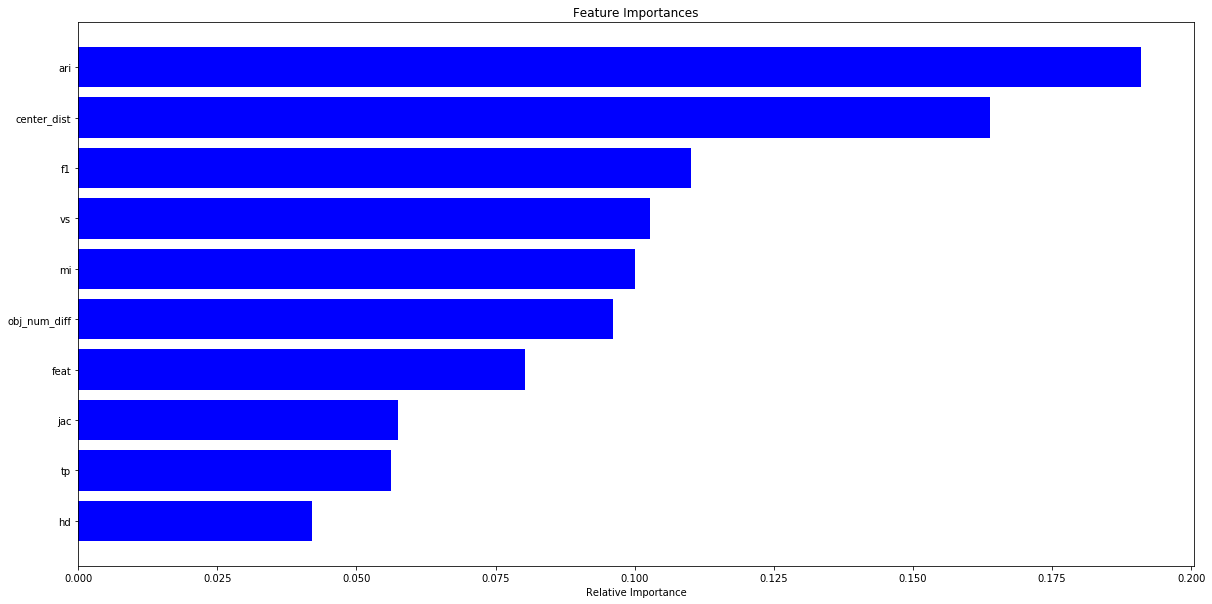

In [16]:
best_clf_rf.fit(X, y)

features = X.columns
importances = best_clf_rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()